In [27]:
!pip install torch torchvision torch-geometric numpy matplotlib

In [28]:
import torch
import torch.utils
import torch.utils.data
from torchvision import datasets, transforms
import torchvision
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import numpy as np
import random

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Set the seed
set_seed(42)


BATCH_SIZE = 256

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])

train_dataset = datasets.FashionMNIST(root='./data', transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', transform=transform, download=True)


train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [29]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')


Using device: cuda


In [ ]:
import matplotlib.pyplot as plt
Image, Label = next(iter(train_loader))
grid_img = torchvision.utils.make_grid(Image, nrow=8, normalize=True)

# Convert the grid image tensor to a NumPy array for plotting
np_img = grid_img.permute(1, 2, 0).numpy()

plt.figure(figsize=(10, 10))
plt.imshow(np_img, cmap='gray')
plt.title('Batch of Images from train_loader')
plt.show()

In [31]:
import torch.nn as nn


class Generator(nn.Module):
    def __init__(self, z_dim):
        super(Generator, self).__init__()
        self.z_dim = z_dim
        self.l1 = nn.Linear(z_dim, 7*7*128)
        self.lr1 = nn.LeakyReLU(0.2, inplace=True)
        self.main = nn.Sequential(
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.l1(x)
        x = self.lr1(x)
        x = x.view(x.size(0), 128, 7, 7)
        return self.main(x)
    
    
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        self.conv_blocks = nn.Sequential(
            nn.Conv2d(1, 64, 3, 2, 1),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.ZeroPad2d((0, 1, 0, 1)),
            nn.BatchNorm2d(128, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.BatchNorm2d(256, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25),
            nn.Conv2d(256, 512, 3, 1, 1),
            nn.BatchNorm2d(512, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout2d(0.25)
        )

        ds_size = 4  # Output size after convolutions
        self.adv_layer = nn.Sequential(nn.Linear(512 * ds_size * ds_size, 1))

    def forward(self, img):
        out = self.conv_blocks(img)
        out = out.flatten(start_dim=1)
        validity = self.adv_layer(out)
        return validity


In [32]:
import torch.nn as nn
from torch_geometric.nn.conv import GATConv
from torch_geometric.nn import global_mean_pool

class GATfewshot(nn.Module):

    def __init__(self, in_channels, hidden_channels, out_channels, num_heads=4, dropout=0.3):
        super(GATfewshot, self).__init__()
        self.gat1 = GATConv(in_channels, hidden_channels, num_heads, False, dropout)
        self.gat2 = GATConv(hidden_channels, out_channels, 1, False, dropout)

    def forward(self, x, edge_index, batch_size):
        out = self.gat1(x, edge_index)
        out = torch.relu(out)
        out = self.gat2(out, edge_index)
        out = global_mean_pool(out, batch_size)
        return out


# class Generator(nn.Module):
#     def __init__(self, z_dim):
#         super(Generator, self).__init__()
#         self.z_dim = z_dim
#         self.l1 = nn.Linear(z_dim, 256)
#         self.model = nn.Sequential(
#             nn.ConvTranspose2d(256, 64, 4, 1, 0),
#             nn.BatchNorm2d(64),
#             nn.LeakyReLU(inplace=True),
#             nn.ConvTranspose2d(64, 32, 4, 2, 2),
#             nn.LeakyReLU(inplace=True),
#             nn.ConvTranspose2d(32, 16, 4, 2, 0),
#             nn.LeakyReLU(inplace=True),
#             nn.ConvTranspose2d(16, 1, 4, 2, 1),
#             nn.Sigmoid()
#         )

#     def forward(self, z):
#         z = self.l1(z)
#         z = z.view(z.size(0), 256, 1, 1)
#         return self.model(z)


# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()
#         self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=2, padding=1)
#         self.conv2 = nn.Conv2d(64, 16, kernel_size=3, stride=2, padding=1)
#         self.fc1 = nn.Linear(16 * 7 * 7, 8)
#         self.fc2 = nn.Linear(8, 1)
#         self.lr1 = nn.LeakyReLU(0.3, inplace=True)
#         self.lr2 = nn.LeakyReLU(0.3, inplace=True)
        

#     def forward(self, x):
#         x = self.conv1(x)
#         x = self.conv2(x)
#         x = self.lr1(x)
#         x = x.flatten(start_dim=1)
#         x = self.fc1(x)
#         x = self.lr2(x)
#         x = self.fc2(x)
#         return x

    
# class Generator(nn.Module):
#     def __init__(self, z_dim):
#         super(Generator, self).__init__()
#         self.z_dim = z_dim
# #         self.l1 = nn.Linear(z_dim, 256)
#         self.model = nn.Sequential(
#             nn.Linear(z_dim, 128),
#             nn.LeakyReLU(inplace=True),
#             nn.Linear(128, 256),
#             nn.LeakyReLU(inplace=True),
#             nn.Linear(256, 28*28),
#             nn.Sigmoid()
#         )

#     def forward(self, z):
#         z = self.model(z)
#         z = z.view(z.size(0), 1, 28, 28)
#         return z

# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()
#         self.model = nn.Sequential(
#             nn.Linear(28*28, 256),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(256, 64),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Linear(64, 1)
#         )

#     def forward(self, x):
#         x = x.view(x.size(0), -1)
#         x = self.model(x)
#         return x



In [33]:
from itertools import product

def create_grid_edge_index(size):
    nodes = list(product(range(size), range(size)))
    edges = []

    for i, (x, y) in enumerate(nodes):
        if x < size - 1:
            edges.append((i, i + size))  # Connect to pixel below
        if y < size - 1:
            edges.append((i, i + 1))  # Connect to pixel to the right

    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()
    return edge_index


size=28
edge_index = create_grid_edge_index(size)

In [34]:
class GraphDataset(torch.utils.data.Dataset):
    def __init__(self, images):
        self.images = images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        image = image.view(-1, 1)  # Each pixel is a node with 1 feature (its intensity)
        return Data(x=image, edge_index=edge_index)


# Convert Omniglot dataset to graph dataset
graph_dataset = GraphDataset([data[0] for data in test_dataset])
graph_loader = DataLoader(graph_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [35]:
Disc(torch.randn(256,1,28,28).to(device)).shape

torch.Size([256, 1])

In [44]:
gat_in_channels = 1
gat_hidden_channels = 64
gat_out_channels = 100

z_dim = 100
g_hidden_dim = 64
g_out_dim = 1

Disc = Discriminator()
Genr = Generator(z_dim)
GAT = GATfewshot(gat_in_channels,gat_hidden_channels,gat_out_channels)


# def weights_init_normal(m):
#     classname = m.__class__.__name__
#     if classname.find('Conv') != -1 or classname.find('Linear') != -1:
#         nn.init.normal_(m.weight.data, 0.0, 0.02)
#     elif classname.find('BatchNorm') != -1:
#         nn.init.normal_(m.weight.data, 1.0, 0.02)
#         nn.init.constant_(m.bias.data, 0)

# Genr.apply(weights_init_normal)
# Disc.apply(weights_init_normal)

Disc.to(device)
Genr.to(device)
# GAT.to(device)



# Loss and optimizers
criterion = nn.BCEWithLogitsLoss()
criterion1 = nn.L1Loss()
optimizer_d = torch.optim.Adam(Disc.parameters(), lr=1e-4)
optimizer_g = torch.optim.Adam(Genr.parameters(), lr=4e-4)
# optimizer_gat = torch.optim.Adam(GAT.parameters(), lr=1e-3)

In [45]:
# Training loop
num_epochs = 20
Disc.train()
Genr.train()
GAT.train()

for epoch in range(num_epochs):
    d_l_r = 0
    d_l_f = 0
    g_l = 0
    gat_l = 0
    for data in graph_loader:
        images = data.x
        batch_size = images.size(0) // (28 * 28)
        images = images.view(batch_size, 28, 28, 1).permute(0, 3, 1, 2).to(device)

        labels = torch.ones(batch_size, 1).to(device) * 0.9  # Real images
        fake_labels = torch.zeros(batch_size, 1).to(device) * 0.1  # Fake images

        # Train Discriminator
        optimizer_d.zero_grad()
        real_outputs = Disc(images)
        d_loss_real = criterion(real_outputs, labels)

        z = torch.randn(batch_size, z_dim).to(device)
        fake_images = Genr(z)
        fake_outputs = Disc(fake_images.detach())
        d_loss_fake = criterion(fake_outputs, fake_labels)
        d_loss = (d_loss_real + d_loss_fake)/2
        d_loss.backward()
        optimizer_d.step()

        # Train Generator
        optimizer_g.zero_grad()
        fake_outputs = Disc(fake_images)
        g_loss = criterion(fake_outputs, labels)
        g_loss.backward()
        optimizer_g.step()

#         # # Train GAT
#         optimizer_gat.zero_grad()
#         g_features = GAT(data.x.to(device), data.edge_index.to(device), data.batch.to(device))
#         g_features = g_features.view(batch_size, z_dim)  # Reshape to match the Generator input
#         fake_images = Genr(g_features)
#         gat_outputs = Disc(fake_images)
#         gat_loss = criterion(gat_outputs, labels)
#         gat_loss.backward()
#         optimizer_gat.step()

        d_l_r += d_loss_real.item()
        d_l_f += d_loss_fake.item()
        g_l += g_loss.item()
#         gat_l += gat_loss.item()

    print(f'Epoch [{epoch+1}/{num_epochs}] | D Loss: {d_loss_real.item() + d_loss_fake.item()} | G Loss: {g_loss.item()}')
#     print(f'Epoch [{epoch+1}/{num_epochs}] | D Loss: {(d_l_r+d_l_f)/len(graph_loader)} | G Loss: {((g_l)/len(graph_loader))} | GAT Loss: {gat_l/len(graph_loader)}')



Epoch [1/20] | D Loss: 0.7961150109767914 | G Loss: 1.7987960577011108
Epoch [2/20] | D Loss: 0.9524007737636566 | G Loss: 1.7546876668930054
Epoch [3/20] | D Loss: 1.1616477966308594 | G Loss: 1.5566190481185913
Epoch [4/20] | D Loss: 0.47881292551755905 | G Loss: 3.5197436809539795
Epoch [5/20] | D Loss: 0.6104738414287567 | G Loss: 2.498516321182251
Epoch [6/20] | D Loss: 0.967878669500351 | G Loss: 2.0525062084198
Epoch [7/20] | D Loss: 0.7013465464115143 | G Loss: 2.2090845108032227
Epoch [8/20] | D Loss: 0.6631487607955933 | G Loss: 2.351200580596924
Epoch [9/20] | D Loss: 0.6125251352787018 | G Loss: 2.547684669494629
Epoch [10/20] | D Loss: 0.5513623654842377 | G Loss: 2.484543561935425
Epoch [11/20] | D Loss: 0.6675723791122437 | G Loss: 2.6088645458221436
Epoch [12/20] | D Loss: 0.7554274797439575 | G Loss: 3.1557230949401855
Epoch [13/20] | D Loss: 0.886449545621872 | G Loss: 2.4708032608032227
Epoch [14/20] | D Loss: 0.7049529850482941 | G Loss: 2.4392995834350586
Epoch [15

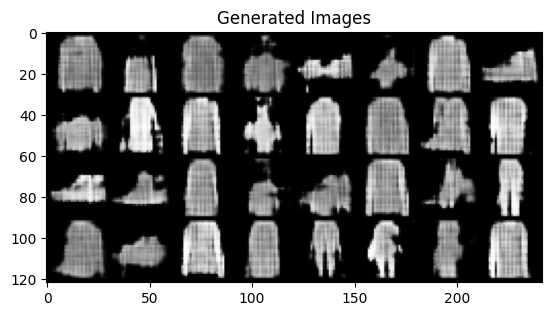

In [46]:
# Evaluation
Disc.eval()
Genr.eval()
GAT.eval()
with torch.no_grad():
    z = torch.randn(32, z_dim).to(device)
    fake_images = Genr(z).cpu()
    grid_img = torchvision.utils.make_grid(fake_images, nrow=8, normalize=True)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.title('Generated Images')
    plt.show()

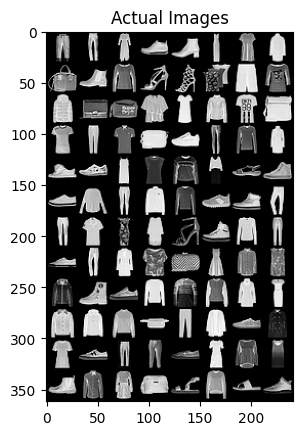

In [39]:
# Evaluation
with torch.no_grad():
    grid_img = torchvision.utils.make_grid(images.cpu(), nrow=8, normalize=True)
    plt.imshow(grid_img.permute(1, 2, 0))
    plt.title('Actual Images')
    plt.show()